In [1]:
import torch
import os
import numpy as np
import sys
import time
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

sys.path.append("../")
from src.train import load_processed_data, format_data
from src.model import GRUSurrogate, LSTMSurrogate

from plot_utils import plot_temperature_sequences

## 1. Load data and model

In [2]:
run_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250805_152136"
data_dir = os.path.join(run_dir, "processed")
device = "cuda:0"

# Load and format data
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data(data_dir)
train_loader, val_loader, test_loader, G = format_data(X_train, y_train, X_val, y_val, X_test, y_test)

# Build model
#model = GRUSurrogate(n_gas=G).to(device)
model = LSTMSurrogate(n_gas=G, hidden=128, num_layers=1).to(device)

# Load model parameters
model_dir = os.path.join(run_dir, "model_lstm.pth")
model.load_state_dict(torch.load(model_dir, map_location=device, weights_only=False))

<All keys matched successfully>

## 2. Run evaluation of model

In [3]:
y_pred_list, y_target_list = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        y_pred = model(xb).cpu().numpy()
        y_target = yb.cpu().numpy()
        
        # Save the data
        y_pred_list.append(y_pred)
        y_target_list.append(y_target)

y_pred_numpy = np.concatenate(y_pred_list)
y_target_numpy = np.concatenate(y_target_list)

rmse = np.sqrt(mean_squared_error(y_target_numpy, y_pred_numpy))
r2   = r2_score(y_target_numpy, y_pred_numpy)
print(f"RMSE: {rmse}, R2: {r2}")

RMSE: 0.0015756273450830457, R2: 0.9999563694000244


In [7]:
y_pred_numpy[:8]

array([0.7520866 , 0.79316556, 0.8267474 , 0.86013377, 0.89149326,
       0.9225807 , 0.9528859 , 0.976506  ], dtype=float32)

In [6]:
y_target_numpy[:8]

array([0.75238365, 0.792697  , 0.826542  , 0.85973126, 0.89088327,
       0.9233676 , 0.95238334, 0.9760593 ], dtype=float32)

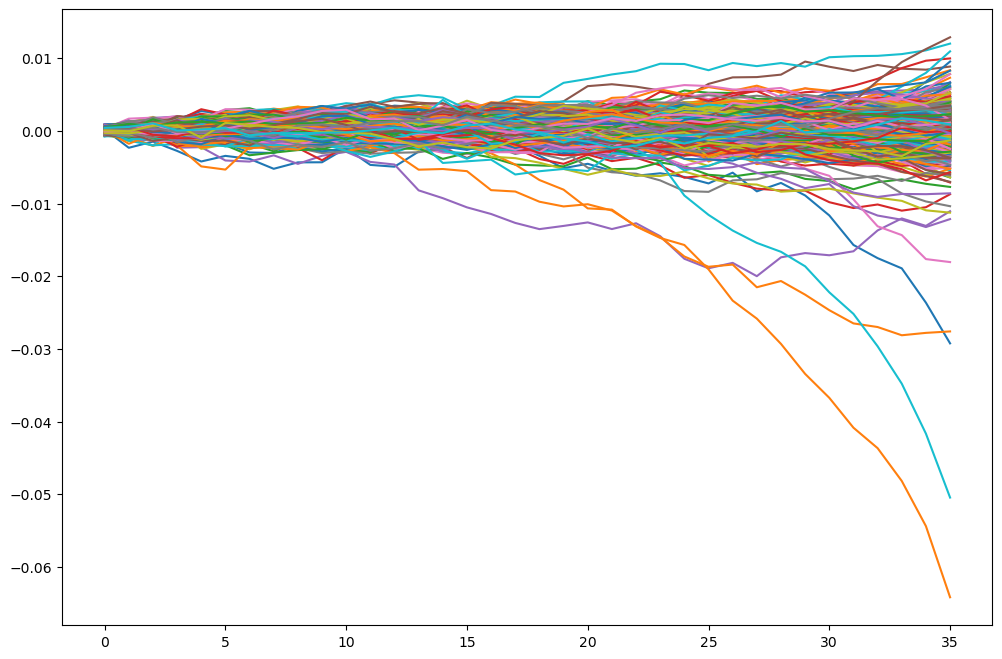

In [4]:
y_target_em_paths = y_target_numpy.reshape(-1, 36).T
y_pred_em_paths = y_pred_numpy.reshape(-1, 36).T

y_diff = y_target_em_paths - y_pred_em_paths

plt.figure(figsize=(12,8))
plt.plot(y_diff)
plt.show()

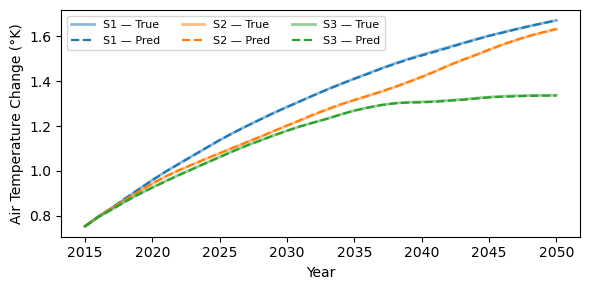

In [5]:
plot_temperature_sequences(y_target_numpy, y_pred_numpy, seq_len=36, n_samples=3, seed=4,
                   years=np.arange(2015, 2015+36), 
                   savepath="plots/test_seq_cicero_net.pdf")

## 4. Small speed test

In [ ]:
def time_single_step_preds(model, data_loader, device="cuda", return_latency=False, warmup=True):

    model.eval().to(device)
    preds = []
    latencies = []

    if warmup:
        with torch.inference_mode():
            for batch in data_loader:
                xb = batch[0] if isinstance(batch, (tuple, list)) else batch
                xb = xb.to(device, non_blocking=True)
                _ = model(xb[:1])
                torch.cuda.synchronize()
                break

    with torch.inference_mode():
        for batch in data_loader:
            xb = batch[0] if isinstance(batch, (tuple, list)) else batch
            xb = xb.to(device, non_blocking=True)
            B = xb.shape[0]

            for i in range(B):
                x_i = xb[i:i+1]
                torch.cuda.synchronize()
                t0 = time.perf_counter()
                y_hat_i = model(x_i)
                t1 = time.perf_counter()

                latencies.append(t1 - t0)
                preds.append(float(y_hat_i.squeeze().detach().cpu().numpy()))

    preds = np.asarray(preds, dtype=float)
    if return_latency:
        return preds, np.asarray(latencies, dtype=float)
    return preds

In [25]:
# preds only
preds = time_single_step_preds(model, test_loader, device="cuda", return_latency=False)

# preds + per-call latencies (seconds)
preds, lat = time_single_step_preds(model, test_loader, device="cuda", return_latency=True)
print(f"mean latency = {lat.mean():.5f} s")

mean latency = 0.00027 s
